# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  






При запуске на комьютере появлялась ошибка, что недостаточно памяти, поэтому модели обучались на Google Cloud. Использовался не весь датасет, а его часть, поскольку обучение только 1-2 эпох на целом датасете для одной модели занимало всю ночь.   
Код, который использовался для обучения моделей на Google Cloud:

In [ ]:
import os
import gensim
import json
import pandas as pd
import numpy as np
from string import punctuation
from nltk.corpus import stopwords
from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SEED = 42
np.random.seed(SEED)

punct = punctuation + '«»—…“”*№–'
stopwords = stopwords.words('english')


def tokenizer(text):
    return [word.strip(punct) for word in text.lower().split() if word.isalpha()]

class MyModel(nn.Module):
    
    def __init__(self, embed_size, hidden_size, kernels,
                 freeze_param=False, weights=None,
                 num_embeddings=3000000):
        super(MyModel, self).__init__()
        
        if weights is not None: 
            if freeze_param:
                self.embedding = nn.Embedding.from_pretrained(weights,
                                                              freeze=True)
            elif not freeze_param:
                self.embedding = nn.Embedding.from_pretrained(weights,
                                                              freeze=False)
        else:
            self.embedding = nn.Embedding(num_embeddings, embed_size)
            nn.init.uniform_(self.embedding.weight)
        
        self.convs = nn.ModuleList([nn.Conv1d(embed_size,
                                              hidden_size,
                                              k,
                                              padding=5) for k in kernels])
        
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

def create_model(weights, freeze):
    tt.cuda.empty_cache()

    model = MyModel(weights=weights,
                embed_size=300,
                hidden_size=128,
                kernels=[2,3,4],
                freeze_param=freeze)

    return model

def train(model, train_iterator, validation_iterator,
          optimiser, scheduler, criterion, epochs):
    
    min_loss = np.inf
    no_improv_cnt = 0
    lr_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        loss_list = []
        val_loss_list = []
        
        for batch in train_iterator:
            
            optimiser.zero_grad()
            pred = model.forward(batch.text[0])
            loss = criterion(pred, batch.label)
            loss_list.append(loss.item())
            loss.backward()
            optimiser.step()
        
        with tt.no_grad():
            for val_batch in validation_iterator:
                val_pred = model.forward(val_batch.text[0])
                val_loss = criterion(val_pred, val_batch.label)
                val_loss_list.append(val_loss.item())

        train_loss = np.mean(loss_list)
        train_loss_history.append(train_loss)
        val_loss = np.mean(val_loss_list)
        val_loss_history.append(val_loss)
        
        lr_history.append(optimiser.param_groups[0]['lr'])
                
        print('[Epoch: {:d}] Train_loss: {:.3f} Val_loss: {:.3f} Lr: {}'.format(
            epoch, train_loss, val_loss, optimiser.param_groups[0]['lr'])) 
                
        if val_loss < min_loss :
            min_loss = val_loss
            no_improv_cnt = 0
        elif no_improv_cnt < scheduler.patience:
            no_improv_cnt += 1
        else:
            break
            
        scheduler.step(val_loss)    
        
    return model, lr_history, train_loss_history, val_loss_history

def test(model, test_iter, criterion):
    model.eval()
    test_loss_history = []
    correct = 0

    with tt.no_grad():
        for batch in test_iter:
            output = model(batch.text[0])
            test_loss = criterion(output, batch.label)
            test_loss_history.append(test_loss.item())

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(batch.label.view_as(pred)).sum().item()

    test_loss = np.mean(test_loss_history)
    print('\nTest set: Average loss: {:.3f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_iter.dataset),
        100. * correct / len(test_iter.dataset)))
    
    return test_loss, correct

def main():

    df = pd.read_csv('data/imdb_master.csv', encoding='latin-1', index_col=0)
    
    pd.concat([df[df['type'] == 'train'][:1000],
               df[df['type'] == 'train'][12500:13500],
               df[df['type'] == 'train'][25000:26000]]).to_csv("data/train.csv", index=False)
    pd.concat([df[df['type'] == 'test'][:1000],
               df[df['type'] == 'test'][12500:13500]]).to_csv('data/test.csv', index=False)
    
    classes={
    'neg': 0,
    'unsup': 1,
    'pos': 2
    }
    
    TEXT = Field(include_lengths=True,
             batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=stopwords)

    LABEL = LabelField(dtype=tt.int64, 
              use_vocab=True, 
              preprocessing=lambda x: classes[x])

    datafields = [("type", None),
              ("text", TEXT),
              ("label", LABEL),
              ("file", None)]

    trn = TabularDataset(
            path="data/train.csv",
            format='csv',
            skip_header=True,
            fields=datafields)
 
    test_set = TabularDataset(
           path="data/test.csv",
           format='csv',
           skip_header=True,
           fields=datafields)

    TEXT.build_vocab(trn, min_freq=5)
    LABEL.build_vocab(trn)

    train_set, valid = trn.split(0.7, stratified=True)

    batch_size = 32
    epochs = 10

    train_iter, val_iter, test_iter = BucketIterator.splits(
                        (train_set, valid, test_set),
                        batch_sizes=(batch_size, batch_size, batch_size),
                        sort_key=lambda x: len(x.text),
#                         sort_within_batch=False,
                        shuffle=True)

    print('Started loading vectors')

    model = gensim.models.KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec')
    weights = tt.FloatTensor(model.vectors)

    print('Finished loading vectors')

    freeze_params = [False, True, None]
    weights_params = [weights, weights, None]
  
    accuracy_history = []

    for i, (freeze_param, weights_param) in enumerate(zip(freeze_params,
                                                          weights_params)):
        model = create_model(weights_param, freeze_param)

        criterion = nn.CrossEntropyLoss()

        if not os.path.exists('model{}.pt'.format(i)):
        
            optimiser = optim.Adam(model.parameters())
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser,
                                                             patience=5,
                                                             verbose=True,
                                                             cooldown=5)
            
            print('Started training model {}'.format(i))
        
            model, lr_history, train_loss, val_loss = train(model,
                                                            train_iter,
                                                            val_iter,
                                                            optimiser,
                                                            scheduler,
                                                            criterion,
                                                            epochs)
            try:
                tt.save(model.state_dict(),'model{}.pt'.format(i))
            except:
                print('model{}.pt not saved'.format(i))

            with open('lr_history_{}'.format(i), 'w', encoding='utf-8') as fw:
                json.dump(lr_history, fw, ensure_ascii=False)
            with open('train_loss_{}'.format(i), 'w', encoding='utf-8') as fw:
                json.dump(train_loss, fw, ensure_ascii=False)
            with open('val_loss_{}'.format(i), 'w', encoding='utf-8') as fw:
                json.dump(val_loss, fw, ensure_ascii=False)

        else:
            model.load_state_dict(tt.load('model{}.pt'.format(i)))

        print('Started testing model {}'.format(i))
        
        test_loss, accuracy = test(model, test_iter, criterion)
        
        with open('test_loss_{}'.format(i), 'w', encoding='utf-8') as fw:
            json.dump(test_loss, fw, ensure_ascii=False)
        
        accuracy_history.append(accuracy)
    
    with open('accuracy_', 'w', encoding='utf-8') as fw:
        json.dump(accuracy_history, fw, ensure_ascii=False)


if __name__ == '__main__':
    main()

### Learning rate vs number of epochs

In [2]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [3]:
def plot_lr(i, title):
    
    with open('lr_history_{}'.format(i), 'r') as f:
        lr = json.load(f)
        
    plt.plot(range(len(lr)), lr)
    plt.title('Learning rate vs number of epochs\n({})'.format(title))
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')

Model with frozen weights

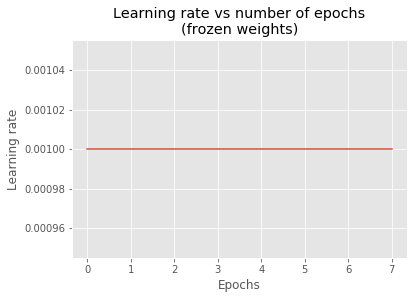

In [4]:
plot_lr(0, 'frozen weights')

Model with initialization from pretrained weights

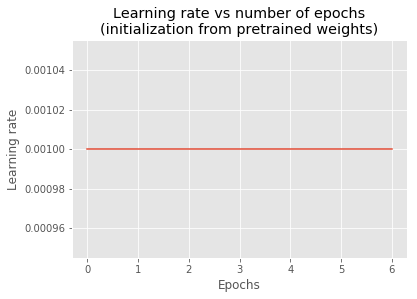

In [5]:
plot_lr(1, 'initialization from pretrained weights')

Model with random initialization

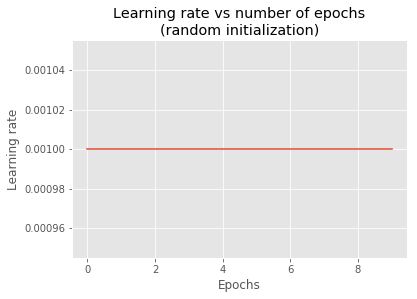

In [6]:
plot_lr(2, 'random initialization')

### Validation curve

In [7]:
import numpy as np

In [8]:
def get_values(name, i):
    with open('{}_{}'.format(name, i), 'r') as f:
        values = json.load(f)
    return values

In [9]:
def plot_loss_epochs(i, title):
    
    train = get_values('train_loss', i)
    val = get_values('val_loss', i)
    test = get_values('test_loss', i)
    
    plt.plot(range(len(train)), train, label='train_loss')
    plt.plot(range(len(val)), val, label='val_loss')

    plt.title('train_loss vs val_loss\n({})'.format(title))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="best")

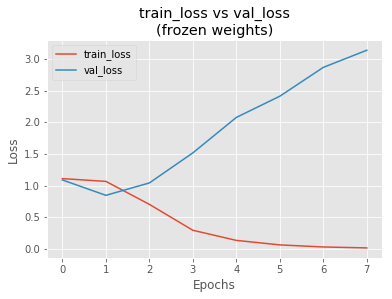

In [10]:
plot_loss_epochs(0, 'frozen weights')

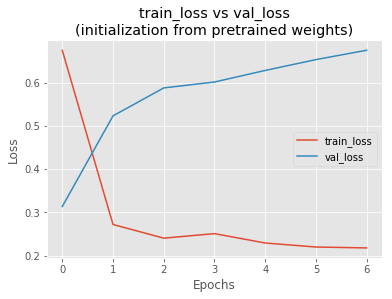

In [11]:
plot_loss_epochs(1, 'initialization from pretrained weights')

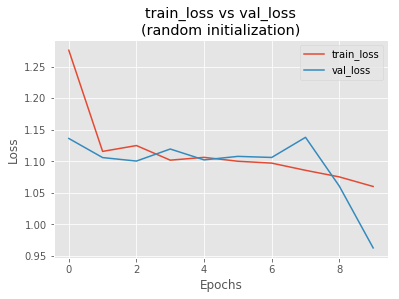

In [12]:
plot_loss_epochs(2, 'random initialization')

In [13]:
train_loss_mean_0 = np.mean(get_values('train_loss', 0))
train_loss_mean_1 = np.mean(get_values('train_loss', 1))
train_loss_mean_2 = np.mean(get_values('train_loss', 2))
train = [train_loss_mean_0, train_loss_mean_1, train_loss_mean_2]
train

[0.42654486453289847, 0.3006189480117518, 1.1143238525498997]

In [14]:
val_loss_mean_0 = np.mean(get_values('val_loss', 0))
val_loss_mean_1 = np.mean(get_values('val_loss', 1))
val_loss_mean_2 = np.mean(get_values('val_loss', 2))
val = [val_loss_mean_0, val_loss_mean_1, val_loss_mean_2]
val

[1.872501291334629, 0.5690588823386601, 1.093980610370636]

In [15]:
test_loss_mean_0 = np.mean(get_values('test_loss', 0))
test_loss_mean_1 = np.mean(get_values('test_loss', 1))
test_loss_mean_2 = np.mean(get_values('test_loss', 2))
test = [test_loss_mean_0, test_loss_mean_1, test_loss_mean_2]
test

[5.801786193771968, 3.283449543846978, 1.0144108817690896]

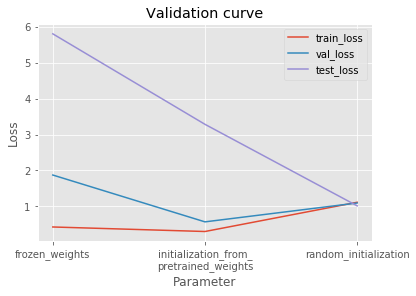

In [16]:
plt.plot(range(3), train, label='train_loss')
plt.plot(range(3), val, label='val_loss')
plt.plot(range(3), test, label='test_loss')

plt.title('Validation curve')
plt.xlabel('Parameter')
plt.xticks([0, 1, 2], ['frozen_weights',
                        'initialization_from_\npretrained_weights',
                        'random_initialization'])
plt.ylabel('Loss')
plt.legend(loc="best")

In [17]:
accuracy = get_values('accuracy', '')
for i, acc in enumerate(accuracy):
    print('Accuracy for model {}: {}/2000 ({:.0f}%)'.format(
        i, acc, 100. * acc / 2000))

Accuracy for model 0: 1100/2000 (55%)
Accuracy for model 1: 1176/2000 (59%)
Accuracy for model 2: 909/2000 (45%)
